In [7]:
# sunspots time-series 데이터를 이용하여 경향성 예측

import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import urllib
import ssl

In [2]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) # channel 부분의 차원을 만들어주어야 함.
    ds = tf.data.Dataset.from_tensor_slices(series) # list나 numpy를 tensor로 변환
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:])) #w[:-1] 마지막 인덱스 전까지는 feature로, w[-1:] 마지막 인덱스는 label로 활용하겠다는 의미 
    return ds.batch(batch_size).prefetch(1)

In [4]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/Sunspots.csv'
urllib.request.urlretrieve(url, 'sunspots.csv')

time_step = []
sunspots = []

with open('sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader) #첫 줄은 column이니까 그냥 넘어가기
  for row in reader:
    sunspots.append(row[2])
    time_step.append(row[0])

series = np.array(sunspots).astype(np.float64) 

# normalization 절차
min = np.min(series)
max = np.max(series)
series -= min
series /= max

time = np.array(time_step)

In [9]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

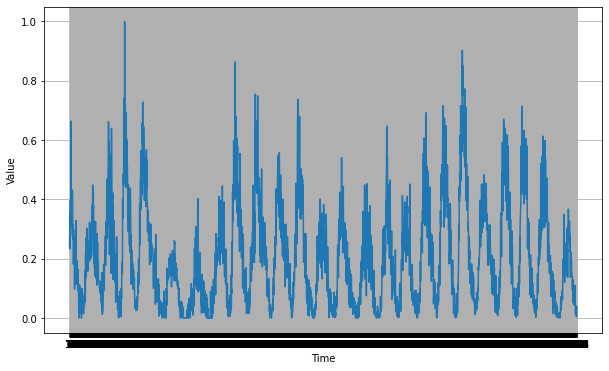

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
# 3000번째까지는 train_data로 분류, 그 이후부터는 validation_data
split_time = 3000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000 #1000번째 index까지 중에서 shuffle, 그게 다 끝나면 그 다음 1000개 중에 shuffle

train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]), # 1은 아까 channel 부분의 차원을 늘려준 것과 일치
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
93/93 [==============================] - 38s 22ms/step - loss: 0.0348 - mae: 0.2028
Epoch 2/100
93/93 [==============================] - 2s 21ms/step - loss: 0.0348 - mae: 0.2028
Epoch 3/100
93/93 [==============================] - 2s 21ms/step - loss: 0.0348 - mae: 0.2028
Epoch 4/100
93/93 [==============================] - 2s 21ms/step - loss: 0.0348 - mae: 0.2028
Epoch 5/100
93/93 [==============================] - 2s 21ms/step - loss: 0.0347 - mae: 0.2028
Epoch 6/100
93/93 [==============================] - 2s 21ms/step - loss: 0.0347 - mae: 0.2028
Epoch 7/100
93/93 [==============================] - 2s 21ms/step - loss: 0.0347 - mae: 0.2028
Epoch 8/100
93/93 [==============================] - 2s 21ms/step - loss: 0.0347 - mae: 0.2027
Epoch 9/100
93/93 [==============================] - 2s 21ms/step - loss: 0.0347 - mae: 0.2027
Epoch 10/100
93/93 [==============================] - 2s 21ms/step - loss: 0.0347 - mae: 0.2027
Epoch 11/100
93/93 [============================

In [15]:
import math

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

window_size = 30
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1,].ravel() #axis 1이 -1인 이유는 모델 예측값 중 -1번째 timestep만 가져오기 위함

result = tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

test_val = 100 * result
score = math.ceil(17 - test_val) #ceil : 소수점 올림하여 정수 리턴
if score > 5:
    score = 5

print(score)

5
